ENHANCED STRING CRYPTOGAN TRAINING
Training Configuration:
  Dataset size: 8 messages
  Epochs: 100
  Max sequence length: 512
  Device: cuda

Epoch   0 | Bob Loss: 5.0243 | Eve Loss: 5.1743 | Bob Acc: 11.8% | Eve Acc: 11.6% | Ratio: 1.03x
Epoch   5 | Bob Loss: 3.9594 | Eve Loss: 4.5686 | Bob Acc: 12.7% | Eve Acc: 11.0% | Ratio: 1.15x
Epoch  10 | Bob Loss: 3.7309 | Eve Loss: 4.2889 | Bob Acc: 9.9% | Eve Acc: 10.7% | Ratio: 1.15x
Epoch  15 | Bob Loss: 3.6062 | Eve Loss: 4.1807 | Bob Acc: 12.1% | Eve Acc: 8.8% | Ratio: 1.16x
  ✅ Checkpoint saved at epoch 20

Epoch  20 | Bob Loss: 3.5833 | Eve Loss: 4.1368 | Bob Acc: 11.8% | Eve Acc: 10.7% | Ratio: 1.15x
Epoch  25 | Bob Loss: 3.4399 | Eve Loss: 3.8198 | Bob Acc: 13.2% | Eve Acc: 11.6% | Ratio: 1.11x
Epoch  30 | Bob Loss: 3.3469 | Eve Loss: 3.6117 | Bob Acc: 11.3% | Eve Acc: 12.7% | Ratio: 1.08x
Epoch  35 | Bob Loss: 3.2930 | Eve Loss: 3.4947 | Bob Acc: 11.3% | Eve Acc: 11.0% | Ratio: 1.06x
  ✅ Checkpoint saved at epoch 40

Epoch  40 | Bob

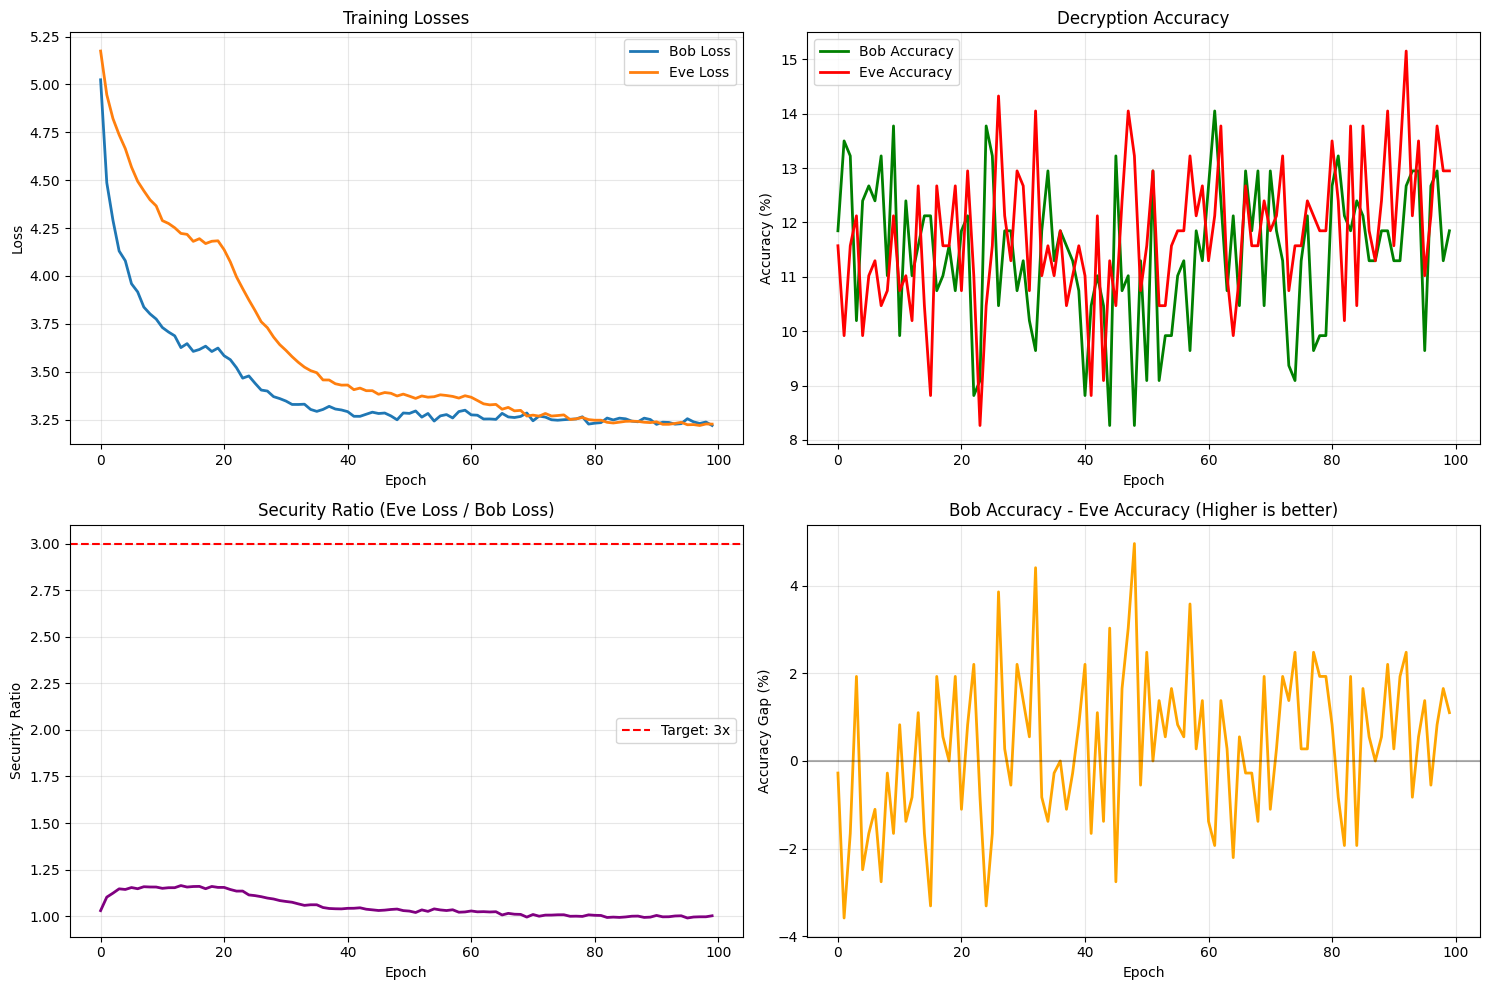

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.special import erfc
from collections import Counter
import matplotlib.pyplot as plt
from difflib import SequenceMatcher

# ============ Complete Training System for Strings ============
class EnhancedStringCryptoTrainer:
    def __init__(self, vocab_size=256, d_model=256, num_heads=8,
                 alice_layers=6, bob_layers=6, eve_layers=8, max_len=512,
                 device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.max_len = max_len

        # Import components
        from part1_enhanced_dcgan import EnhancedDCGANKeyGenerator, StringPreprocessor
        from part2_enhanced_alice import AliceStringEncryption
        from part3_enhanced_bob_eve import BobStringDecryption, EveStringAttack

        # Initialize all components
        self.key_generator = EnhancedDCGANKeyGenerator(device=device)
        self.preprocessor = StringPreprocessor(max_length=max_len)

        self.alice_wrapper = AliceStringEncryption(
            vocab_size, d_model, num_heads, alice_layers, max_len, device
        )
        self.bob_wrapper = BobStringDecryption(
            vocab_size, d_model, num_heads, bob_layers, max_len, device
        )
        self.eve_wrapper = EveStringAttack(
            vocab_size, d_model, num_heads, eve_layers, max_len, device
        )

        # Get the actual networks
        self.alice = self.alice_wrapper.alice
        self.bob = self.bob_wrapper.bob
        self.eve = self.eve_wrapper.eve

        # Optimizers with different learning rates
        self.optimizer_alice = optim.AdamW(
            self.alice.parameters(), lr=0.0003, weight_decay=0.01
        )
        self.optimizer_bob = optim.AdamW(
            self.bob.parameters(), lr=0.0003, weight_decay=0.01
        )
        self.optimizer_eve = optim.AdamW(
            self.eve.parameters(), lr=0.0002, weight_decay=0.01
        )

        # Learning rate schedulers
        self.scheduler_alice = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer_alice, T_0=20, T_mult=2
        )
        self.scheduler_bob = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer_bob, T_0=20, T_mult=2
        )
        self.scheduler_eve = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer_eve, T_0=20, T_mult=2
        )

        # Loss functions
        self.ce_loss = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding

    def train_epoch(self, messages, epoch):
        """
        Train for one epoch on a batch of messages
        messages: list of strings
        """
        batch_size = len(messages)

        # Convert messages to tokens
        message_tokens = self.preprocessor.batch_strings_to_tensor(messages).to(self.device)

        # Generate keys for this batch
        keys = self.key_generator.generate_encryption_keys(
            seq_length=512,
            message=messages[0] if batch_size > 0 else None
        )
        key_sequences = keys['key_sequences']

        alice_losses = []
        bob_losses = []
        eve_losses = []

        # ===== Phase 1: Train Alice and Bob cooperatively =====
        for _ in range(2):  # Train 2 times
            self.optimizer_alice.zero_grad()
            self.optimizer_bob.zero_grad()

            # Alice encrypts
            encrypted = self.alice(message_tokens, key_sequences)

            # Bob decrypts
            bob_logits = self.bob(encrypted, key_sequences)

            # Reconstruction loss
            bob_logits_flat = bob_logits.reshape(-1, bob_logits.size(-1))
            targets_flat = message_tokens.reshape(-1)
            loss_bob = self.ce_loss(bob_logits_flat, targets_flat)

            loss_bob.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.alice.parameters(), 1.0)
            torch.nn.utils.clip_grad_norm_(self.bob.parameters(), 1.0)

            self.optimizer_alice.step()
            self.optimizer_bob.step()

        alice_losses.append(loss_bob.item())
        bob_losses.append(loss_bob.item())

        # ===== Phase 2: Train Eve aggressively =====
        for _ in range(4):  # Train Eve 4 times to make it stronger
            self.optimizer_eve.zero_grad()

            # Get fresh encryption (detached)
            with torch.no_grad():
                encrypted_for_eve = self.alice(message_tokens, key_sequences)

            # Eve attacks
            eve_logits = self.eve(encrypted_for_eve)

            # Eve's loss
            eve_logits_flat = eve_logits.reshape(-1, eve_logits.size(-1))
            loss_eve = self.ce_loss(eve_logits_flat, targets_flat)

            loss_eve.backward()
            torch.nn.utils.clip_grad_norm_(self.eve.parameters(), 1.0)
            self.optimizer_eve.step()

        eve_losses.append(loss_eve.item())

        # ===== Phase 3: Adversarial training for Alice =====
        for _ in range(2):
            self.optimizer_alice.zero_grad()

            encrypted_adv = self.alice(message_tokens, key_sequences)
            eve_logits_adv = self.eve(encrypted_adv)

            # Alice wants to maximize Eve's loss (minimize negative loss)
            eve_logits_adv_flat = eve_logits_adv.reshape(-1, eve_logits_adv.size(-1))
            loss_adversarial = -self.ce_loss(eve_logits_adv_flat, targets_flat)

            # Weight it higher
            (loss_adversarial * 3.0).backward()
            torch.nn.utils.clip_grad_norm_(self.alice.parameters(), 1.0)
            self.optimizer_alice.step()

        # Calculate accuracy metrics
        with torch.no_grad():
            encrypted_eval = self.alice(message_tokens, key_sequences)
            bob_logits_eval = self.bob(encrypted_eval, key_sequences)
            eve_logits_eval = self.eve(encrypted_eval)

            bob_pred = torch.argmax(bob_logits_eval, dim=-1)
            eve_pred = torch.argmax(eve_logits_eval, dim=-1)

            # Calculate accuracy (ignoring padding)
            mask = message_tokens != 0
            bob_correct = ((bob_pred == message_tokens) & mask).sum().item()
            eve_correct = ((eve_pred == message_tokens) & mask).sum().item()
            total_tokens = mask.sum().item()

            bob_accuracy = bob_correct / total_tokens if total_tokens > 0 else 0
            eve_accuracy = eve_correct / total_tokens if total_tokens > 0 else 0

        return {
            'alice_loss': np.mean(alice_losses),
            'bob_loss': np.mean(bob_losses),
            'eve_loss': np.mean(eve_losses),
            'bob_accuracy': bob_accuracy,
            'eve_accuracy': eve_accuracy,
            'security_ratio': loss_eve.item() / (loss_bob.item() + 1e-8)
        }

    def train(self, dataset, num_epochs=100, save_every=20):
        """
        Complete training loop
        dataset: list of string messages
        """
        history = {
            'alice_loss': [],
            'bob_loss': [],
            'eve_loss': [],
            'bob_accuracy': [],
            'eve_accuracy': [],
            'security_ratio': []
        }

        print("="*70)
        print("ENHANCED STRING CRYPTOGAN TRAINING")
        print("="*70)
        print(f"Training Configuration:")
        print(f"  Dataset size: {len(dataset)} messages")
        print(f"  Epochs: {num_epochs}")
        print(f"  Max sequence length: {self.max_len}")
        print(f"  Device: {self.device}")
        print("="*70 + "\n")

        for epoch in range(num_epochs):
            # Sample batch from dataset
            batch_indices = np.random.choice(len(dataset), size=min(8, len(dataset)), replace=False)
            batch_messages = [dataset[i] for i in batch_indices]

            # Train on batch
            epoch_results = self.train_epoch(batch_messages, epoch)

            # Record history
            for key in history.keys():
                history[key].append(epoch_results[key])

            # Print progress
            if epoch % 5 == 0:
                print(f"Epoch {epoch:3d} | "
                      f"Bob Loss: {epoch_results['bob_loss']:.4f} | "
                      f"Eve Loss: {epoch_results['eve_loss']:.4f} | "
                      f"Bob Acc: {epoch_results['bob_accuracy']*100:.1f}% | "
                      f"Eve Acc: {epoch_results['eve_accuracy']*100:.1f}% | "
                      f"Ratio: {epoch_results['security_ratio']:.2f}x")

            # Update learning rates
            self.scheduler_alice.step()
            self.scheduler_bob.step()
            self.scheduler_eve.step()

            # Save checkpoints
            if (epoch + 1) % save_every == 0:
                self.save_checkpoint(epoch + 1)
                print(f"  ✅ Checkpoint saved at epoch {epoch + 1}\n")

        return history

    def save_checkpoint(self, epoch):
        """Save model checkpoint"""
        torch.save({
            'alice': self.alice.state_dict(),
            'bob': self.bob.state_dict(),
            'eve': self.eve.state_dict(),
            'epoch': epoch
        }, f'string_crypto_checkpoint_epoch_{epoch}.pth')


# ============ String-Based Evaluation Metrics ============
class StringCryptoEvaluator:
    """Evaluation metrics for string encryption"""

    @staticmethod
    def string_similarity(str1, str2):
        """Calculate similarity ratio between two strings"""
        return SequenceMatcher(None, str1, str2).ratio()

    @staticmethod
    def character_error_rate(reference, hypothesis):
        """Calculate character-level error rate"""
        if len(reference) == 0:
            return 1.0 if len(hypothesis) > 0 else 0.0

        errors = sum(c1 != c2 for c1, c2 in zip(reference, hypothesis))
        errors += abs(len(reference) - len(hypothesis))

        return errors / len(reference)

    @staticmethod
    def evaluate_system(trainer, test_messages):
        """Comprehensive evaluation on test messages"""
        print("\n" + "="*70)
        print("STRING ENCRYPTION EVALUATION")
        print("="*70)

        results = {
            'bob_similarities': [],
            'eve_similarities': [],
            'bob_cer': [],
            'eve_cer': [],
            'examples': []
        }

        for i, original_msg in enumerate(test_messages[:5]):  # Test on first 5
            # Convert to tensor
            msg_tokens = trainer.preprocessor.string_to_tensor(original_msg).unsqueeze(0).to(trainer.device)

            # Generate keys
            keys = trainer.key_generator.generate_encryption_keys(
                seq_length=512,
                message=original_msg
            )

            # Encrypt
            with torch.no_grad():
                encrypted = trainer.alice(msg_tokens, keys['key_sequences'])

                # Bob decrypts
                bob_logits = trainer.bob(encrypted, keys['key_sequences'])
                bob_tokens = torch.argmax(bob_logits, dim=-1)
                bob_message = trainer.preprocessor.tensor_to_string(bob_tokens[0])

                # Eve attacks
                eve_logits = trainer.eve(encrypted)
                eve_tokens = torch.argmax(eve_logits, dim=-1)
                eve_message = trainer.preprocessor.tensor_to_string(eve_tokens[0])

            # Calculate metrics
            bob_sim = StringCryptoEvaluator.string_similarity(original_msg, bob_message)
            eve_sim = StringCryptoEvaluator.string_similarity(original_msg, eve_message)
            bob_cer = StringCryptoEvaluator.character_error_rate(original_msg, bob_message)
            eve_cer = StringCryptoEvaluator.character_error_rate(original_msg, eve_message)

            results['bob_similarities'].append(bob_sim)
            results['eve_similarities'].append(eve_sim)
            results['bob_cer'].append(bob_cer)
            results['eve_cer'].append(eve_cer)

            results['examples'].append({
                'original': original_msg,
                'bob': bob_message,
                'eve': eve_message
            })

            # Print example
            print(f"\nExample {i+1}:")
            print(f"  📝 Original: '{original_msg}'")
            print(f"  ✅ Bob:      '{bob_message}' (similarity: {bob_sim*100:.1f}%)")
            print(f"  ❌ Eve:      '{eve_message}' (similarity: {eve_sim*100:.1f}%)")

        # Summary statistics
        print("\n" + "="*70)
        print("SUMMARY STATISTICS")
        print("="*70)

        avg_bob_sim = np.mean(results['bob_similarities'])
        avg_eve_sim = np.mean(results['eve_similarities'])
        avg_bob_cer = np.mean(results['bob_cer'])
        avg_eve_cer = np.mean(results['eve_cer'])

        print(f"\nBob (with correct keys):")
        print(f"  Average Similarity: {avg_bob_sim*100:.2f}%")
        print(f"  Average CER: {avg_bob_cer*100:.2f}%")
        print(f"  Status: {'✅ EXCELLENT' if avg_bob_sim > 0.9 else '⚠️ NEEDS IMPROVEMENT'}")

        print(f"\nEve (without keys):")
        print(f"  Average Similarity: {avg_eve_sim*100:.2f}%")
        print(f"  Average CER: {avg_eve_cer*100:.2f}%")
        print(f"  Status: {'✅ SECURE' if avg_eve_sim < 0.3 else '❌ INSECURE'}")

        security_ratio = avg_eve_cer / (avg_bob_cer + 1e-8)
        print(f"\nSecurity Ratio: {security_ratio:.2f}x")
        print(f"  Status: {'✅ STRONG' if security_ratio > 3 else '⚠️ WEAK'}")

        print("\n" + "="*70)

        return results


# ============ Training Plot ============
def plot_training_results(history):
    """Plot training curves"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss curves
    axes[0, 0].plot(history['bob_loss'], label='Bob Loss', linewidth=2)
    axes[0, 0].plot(history['eve_loss'], label='Eve Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training Losses')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy curves
    axes[0, 1].plot([a*100 for a in history['bob_accuracy']], label='Bob Accuracy', linewidth=2, color='green')
    axes[0, 1].plot([a*100 for a in history['eve_accuracy']], label='Eve Accuracy', linewidth=2, color='red')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title('Decryption Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Security ratio
    axes[1, 0].plot(history['security_ratio'], linewidth=2, color='purple')
    axes[1, 0].axhline(y=3, color='r', linestyle='--', label='Target: 3x')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Security Ratio')
    axes[1, 0].set_title('Security Ratio (Eve Loss / Bob Loss)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Accuracy gap
    accuracy_gap = [e - b for b, e in zip(history['bob_accuracy'], history['eve_accuracy'])]
    axes[1, 1].plot([g*100 for g in accuracy_gap], linewidth=2, color='orange')
    axes[1, 1].axhline(y=0, color='k', linestyle='-', alpha=0.3)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy Gap (%)')
    axes[1, 1].set_title('Bob Accuracy - Eve Accuracy (Higher is better)')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('string_crypto_training.png', dpi=150)
    print("Training plot saved as 'string_crypto_training.png'")


# ============ Main Execution ============
if __name__ == "__main__":
    # Sample dataset of messages
    dataset = [
        "Hello World! This is a secret message.",
        "The quick brown fox jumps over the lazy dog.",
        "Encryption and decryption test message number three.",
        "Secure communication is essential for privacy.",
        "Neural networks can learn complex patterns.",
        "This message should be encrypted securely.",
        "Testing the adversarial training system.",
        "Alice encrypts, Bob decrypts, Eve attacks!",
    ]

    # Initialize trainer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    trainer = EnhancedStringCryptoTrainer(device=device)

    # Train
    history = trainer.train(dataset, num_epochs=100, save_every=20)

    # Plot results
    plot_training_results(history)

    # Evaluate
    test_messages = dataset[:5]
    results = StringCryptoEvaluator.evaluate_system(trainer, test_messages)

    print("\n✅ Training complete!")